# [Research Request - Service Data for SJCOG #1476](https://github.com/cal-itp/data-analyses/issues/1476)

explore trying to answer these questions from the issue:

>- share some information from NTD on what % of services are provided by SJRTD.
>- see if NTD can help us tell what each operators need is for that region.
>- see if NTD shows you the operations just in a particular UZA. 
>- Are you able to see specifically within the Tracy boundaries which percentage of service is provided by City of Tracy vs SJRTD?
>- Can NTD tell you the funding for each operator by source?
>- Can you tell what level of 5307, 5311, TDA, LCTOP etc they [operators?] get from there?

Found that [FTA publishes resources and tables related to apportionments](https://www.transit.dot.gov/funding/apportionments/apportionment-resources), including [the data used to calculate apportionments for multiple formula grant programs (5307, STIC, 5311, etc)](https://www.transit.dot.gov/funding/apportionments/formula-apportionments-data). 

Specifially, the data in [National Transit Database Data Used for the Small Transit Intensive Cities (STIC) Apportionments](https://www.transit.dot.gov/funding/apportionments/national-transit-database-data-used-small-transit-intensive-cities-stic) may help answer these questions as it displays the metrics (UPT, VRM, VRH etc) useed to calculate apportionments.


In [1]:
import altair as alt
import pandas as pd
from calitp_data_analysis.tables import tbls
from siuba import _, collect, count, filter, group_by, select, show_query, summarize

# from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# list Cities in San Joaquin County
sj_cities = [
    "Stockton",
    "Escalon",
    "Tracy",
    "Lathrop",
    "Lodi",
    "Manteca",
    "Mountain House",
    "Ripon",
    "Acampo",
    "French Camp",
    "Garden Arcres",
]

[Table 3. FY 2025 Section 5307 and 5340 Urbanized Area Formula Appropriations (Full Year)](https://www.transit.dot.gov/funding/apportionments/table-3-fy-2025-section-5307-and-5340-urbanized-area-formula-0)
confirms the total apportionment dollars for the SJCOG region sent by Wendy. 
<br>Note: Pivot Tables were used to transform the excel data.
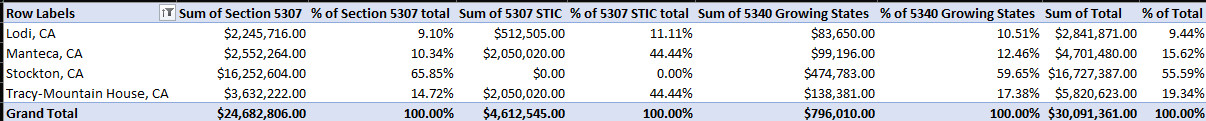

[Table 6. FY 2025 Section 5307 Small Transit Intensive Cities Apportionments (Full Year)](https://www.transit.dot.gov/funding/apportionments/table-6-fy-2025-section-5307-small-transit-intensive-cities-apportionments-0) 
display the 5307 STIC apportionments for the regions (this tabled does not include Stockton UZA)
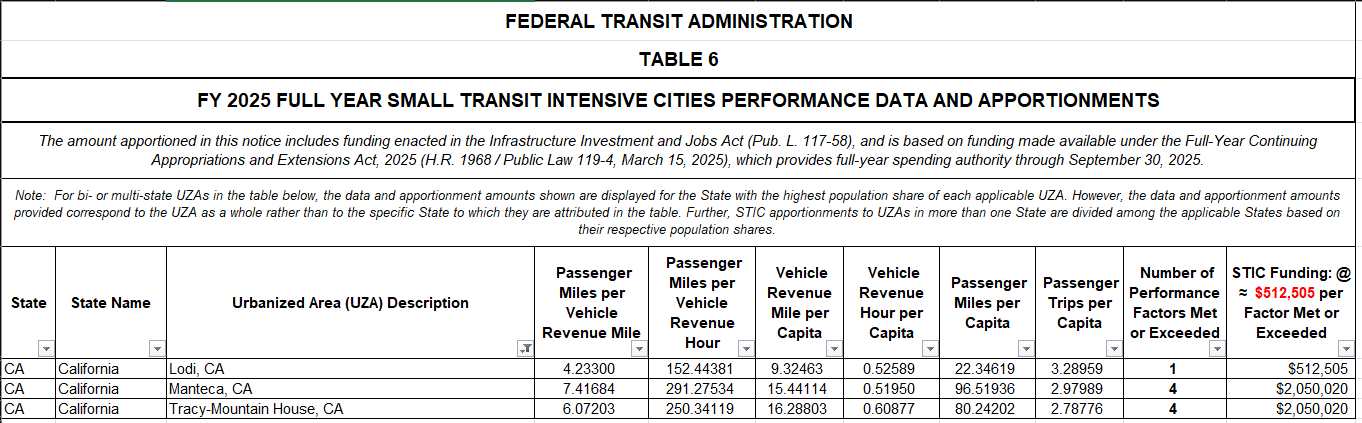

## 1. See if NTD can help us tell what each operators need is for that region.

Need some clarity on what `need` means in this context.

## 2. see if NTD shows you the operations just in a particular UZA.
[National Transit Database Data Used for the Small Transit Intensive Cities (STIC) Apportionments](https://www.transit.dot.gov/funding/apportionments/national-transit-database-data-used-small-transit-intensive-cities-stic). shows the data use to calculate the apportionment of STIC funds for 2025 by uza and/or agency 

Below is the `STIC Apportionment` tab filtered by the UZAs in the  SJ region
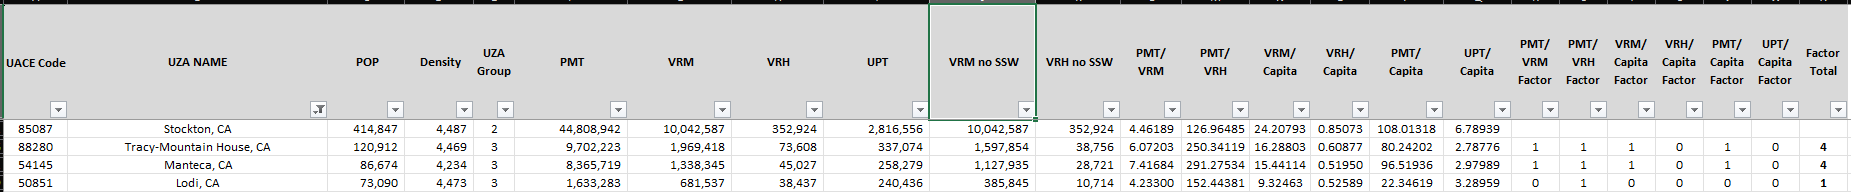

below is the `STIC by Agency` tab filtered by the UZAs in the SJ region. This tab excludes Stockton UZA
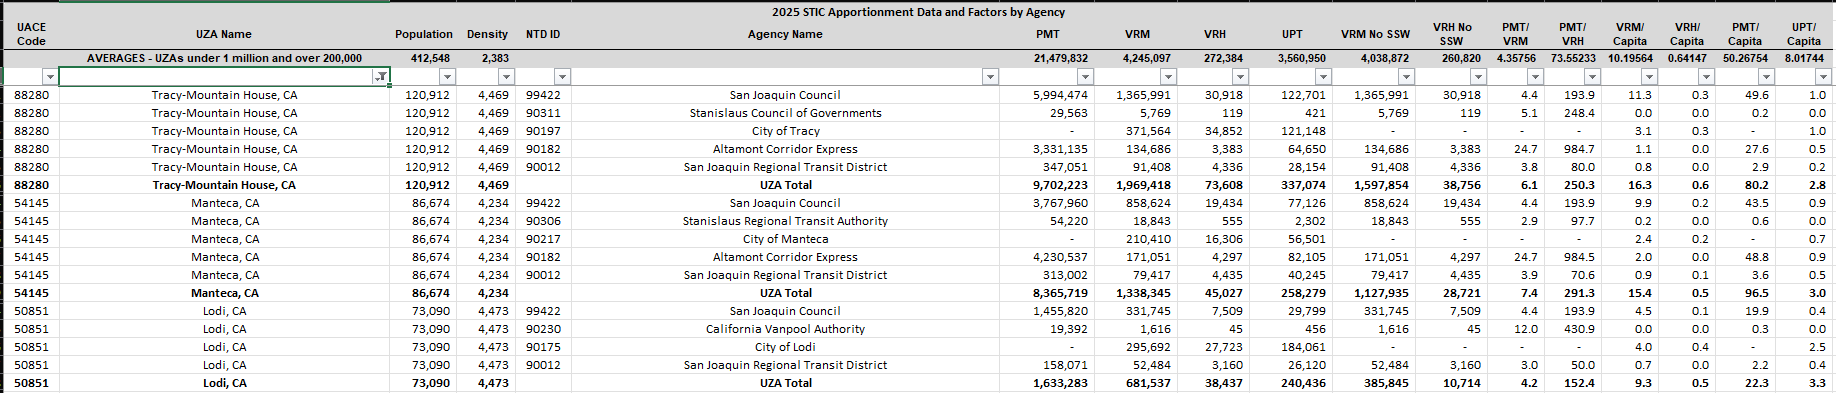

The [National Transit Database Data Used for the Section 5307 Urbanized Area Formula and Section 5339 Bus Formula Apportionments](https://www.transit.dot.gov/funding/apportionments/national-transit-database-data-used-section-5307-urbanized-area-formula-and) displays the operations for Stockton UZA
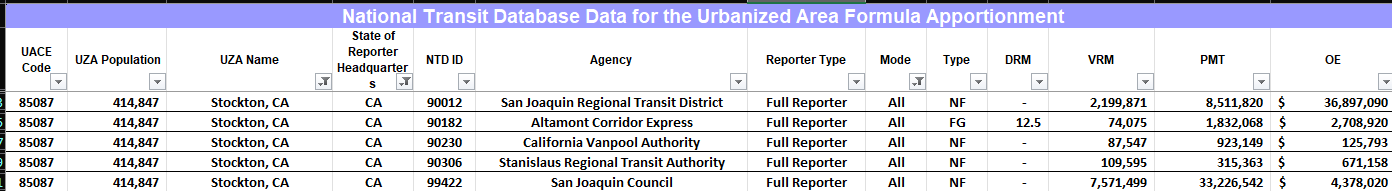


## 3. Are you able to see specifically within the Tracy boundaries which percentage of service is provided by City of Tracy vs SJRTD?
[National Transit Database Data Used for the Small Transit Intensive Cities (STIC) Apportionments](https://www.transit.dot.gov/funding/apportionments/national-transit-database-data-used-small-transit-intensive-cities-stic), shows service metrics used for apportionment calculation. 

Below is a pivot table showing the % of service metrics for `City of Tracy` vs `SJRTD` in the Tracy UZA
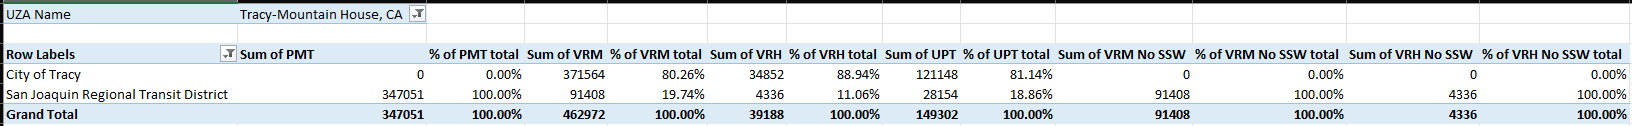


## 4. Can NTD tell you the funding for each operator by source?
## & 
## 5. Can you tell what level of 5307, 5311, TDA, LCTOP etc they [operators?] get from there?
FTA has 2 datasets for federal and state funding for agencies:

- [2022 - 2023 NTD Annual Data - Funding Sources (Federal)](https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Funding-Sources-Federal-/qpjk-b3zw/about_data) 
- [2022 - 2023 NTD Annual Data - Funding Sources (State)](https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Funding-Sources-State-/dd43-h6wv/about_data)

Federal table can tell us the amount of 5307 (urbanized area funds) and 5311 funds go to each operator for 2022-2023. However, the state table does not display specific funding names.

In [3]:
# equivilent to"2022 - 2023 NTD Annual Data - Funding Sources (Federal)" 
# https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Funding-Sources-Federal-/qpjk-b3zw/about_data
fund_source_fed = (
    tbls.mart_ntd_annual_reporting.fct_funding_sources_federal()
    >> filter(
        _.state == "CA",
        _.city.isin(sj_cities)

    )
    >> group_by(
        _.agency_name, 
        _.ntd_id, 
        _.reporter_type, 
        _.uza_name,
        _.city
    )
    >> summarize(
        total_5309_funds=_.fta_capital_program_5309.sum(),
        total_5311_funds=_.fta_rural_progam_5311.sum(),
        total_urbanized_area_funds=_.fta_urbanized_area_formula.sum(),
    )
    >> collect()
)

In [4]:
fund_source_fed

,agency_name,ntd_id,reporter_type,uza_name,city,total_5309_funds,total_5311_funds,total_urbanized_area_funds
0,City of Escalon,91078,Rural Reporter,None,Escalon,0.0,128447.0,0.0
1,"City of Lodi, dba: GrapeLine",90175,Reduced Reporter,"Lodi, CA",Lodi,0.0,0.0,2829407.0
2,"City of Manteca, dba: Manteca Transit",90217,Reduced Reporter,"Manteca, CA",Manteca,0.0,0.0,2785782.0
3,"City of Escalon, dba: eTrans",91078,Reduced Reporter,"Modesto, CA",Escalon,0.0,126606.0,0.0
4,San Joaquin Regional Transit District,90012,Full Reporter,"Stockton, CA",Stockton,0.0,1447381.0,17046394.0
5,"San Joaquin Regional Transit District, dba: Sa...",90012,Full Reporter,"Stockton, CA",Stockton,0.0,1269577.0,17219730.0
6,Altamont Corridor Express,90182,Full Reporter,"Stockton, CA",Stockton,11946856.0,0.0,42230870.0
7,"San Joaquin Council, dba: Dibs",99422,Full Reporter,"Stockton, CA",Stockton,0.0,0.0,0.0
8,San Joaquin Council,99422,Full Reporter,"Stockton, CA",Stockton,0.0,0.0,0.0
9,"City of Tracy, dba: TRACER",90197,Reduced Reporter,"Tracy--Mountain House, CA",Tracy,0.0,0.0,2661252.0


In [5]:
# equivilent to "https://data.transportation.gov/Public-Transit/2022-2023-NTD-Annual-Data-Funding-Sources-State-/dd43-h6wv/about_data"

fund_source_state = (
    tbls.mart_ntd_annual_reporting.fct_funding_sources_state()
    >> filter(
        _.state == "CA",
        _.city.isin(sj_cities)

    )
    >> group_by(
        _.agency_name, 
        _.ntd_id, 
        _.reporter_type, 
        _.uza_name,
        _.city
    )
    >> summarize(
        total_gen_funds=_.general_funds.sum(),
        total_transportation_funds=_.transportation_funds.sum(),
        total_reduced_reporter_funds=_.reduced_reporter_funds.sum(),
    )
    >> collect()
)

In [6]:
fund_source_state

,agency_name,ntd_id,reporter_type,uza_name,city,total_gen_funds,total_transportation_funds,total_reduced_reporter_funds
0,City of Escalon,91078,Rural Reporter,None,Escalon,0.0,0.0,32944.0
1,"City of Lodi, dba: GrapeLine",90175,Reduced Reporter,"Lodi, CA",Lodi,0.0,0.0,445011.0
2,"City of Manteca, dba: Manteca Transit",90217,Reduced Reporter,"Manteca, CA",Manteca,0.0,0.0,3339468.0
3,"City of Escalon, dba: eTrans",91078,Reduced Reporter,"Modesto, CA",Escalon,0.0,0.0,147933.0
4,"San Joaquin Regional Transit District, dba: Sa...",90012,Full Reporter,"Stockton, CA",Stockton,1624806.0,0.0,0.0
5,San Joaquin Regional Transit District,90012,Full Reporter,"Stockton, CA",Stockton,3315549.0,0.0,0.0
6,Altamont Corridor Express,90182,Full Reporter,"Stockton, CA",Stockton,19875244.0,29132862.0,0.0
7,San Joaquin Council,99422,Full Reporter,"Stockton, CA",Stockton,0.0,0.0,0.0
8,"San Joaquin Council, dba: Dibs",99422,Full Reporter,"Stockton, CA",Stockton,0.0,0.0,0.0
9,"City of Tracy, dba: TRACER",90197,Reduced Reporter,"Tracy--Mountain House, CA",Tracy,0.0,0.0,3735134.0
